In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
scaler = MinMaxScaler(feature_range=(-1, 1))

pf = pd.read_csv('data/Google_Stock_Price_Train.csv')
pf_test = pd.read_csv('data/Google_Stock_Price_Test.csv')

pf_test['Volume'] = pf_test['Volume'].str.replace(',','').astype(float)

pf['Volume'] = pf['Volume'].str.replace(',','').astype(float)
pf['Close'] = pf['Close'].str.replace(',','').astype(float)

In [2]:
head_names = list(pf.columns.values)[1:]
head_names_original = head_names.copy()

In [3]:
N = 2
M = 1

In [4]:
def split_data(volume, sequence_size, M):
    data = []
    for index in range(len(volume.to_numpy())-sequence_size): 
        data.append(volume.to_numpy()[index: index+sequence_size])
    data = np.array(data)
    
    vali_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (vali_set_size)
    m = -1-M
    
    x_train = data[:train_set_size ,: -1 ,:]
    y_train = data[:train_set_size ,m:-1,:]
    x_vali = data[train_set_size :,: -1]
    y_vali = data[train_set_size:, m:-1,:]
    
    
    y_train_holder = []
    for i in range(len(y_train)):
        k = []
        for n in range(M):
            k.append(y_train[i][n][:])
        y_train_holder.append(k)
        
    y_vali_holder = []
    for i in range(len(y_vali)):
        k = []
        for n in range(M):
            k.append(y_vali[i][n][:])
        y_vali_holder.append(k)
    
    y_vali, y_train = np.array(y_vali_holder), np.array(y_train_holder)
    return [x_train, y_train, x_vali, y_vali]

In [5]:
def test_data(volume, sequence_size, M):
    data = []
    for index in range(len(volume.to_numpy())-sequence_size): 
        data.append(volume.to_numpy()[index: index+sequence_size])
    data = np.array(data)
    m = -1-M
    x_vali = data[:,: -1]
    y_vali = data[:, m:-1,:]
    y_vali_holder = []
    for i in range(len(y_vali)):
        k = []
        for n in range(M):
            k.append(y_vali[i][n][:])
        y_vali_holder.append(k)
    y_vali= np.array(y_vali_holder)
    return [x_vali, y_vali]

In [6]:
pf_test_head_names = list(pf_test.columns.values)[1:]
pf_test_head_names_original = head_names.copy()
pf_test = pf_test[pf_test_head_names_original]
for i in pf_test_head_names_original:
    pf_test[i] = scaler.fit_transform(pf_test[i].values.reshape(-1,1))
# pf_test

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, input_sequence,M):
#         print('x.shape',x.shape)
        h = torch.zeros(self.num_layers, input_sequence.size(0), self.hidden_dim).requires_grad_()
#         print('h0.shape',h0.shape)
        c = torch.zeros(self.num_layers, input_sequence.size(0), self.hidden_dim).requires_grad_()
#         print('c0.shape',c0.shape)
        out, (hh, cc) = self.lstm(input_sequence, (h.detach(), c.detach()))
#         print('out.shape',out.shape)
        out = self.fc(out[:, -1, :]) 
        out = out.reshape(-1,M,5)
#         print('self.fc(out[:, -1, :]).shape',out.shape)
        return out

In [8]:
def calculate(volume, N, M, num_epochs, num_layers, col_name, x_train, x_vali, y_train_lstm, y_vali_lstm):
    x_train = torch.tensor(x_train).float()
    x_vali = torch.tensor(x_vali).float()
    y_train_lstm = torch.tensor(y_train_lstm).float()
    y_vali_lstm = torch.tensor(y_vali_lstm).float()
    
    input_size = volume.shape[1]
    hidden_layer_size = N * input_size
    output_size = M*5
    
    model = LSTM(input_dim=input_size, hidden_dim=hidden_layer_size, output_dim=output_size, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    
    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    y_train_pred = []
    loss = 0
    for t in range(num_epochs):
        y_train_pred = model(x_train,M)
#         print('y_train_pred',y_train_pred)
#         print('y_train_lstm',y_train_lstm)
#         print('y_train_pred.shape',y_train_pred.shape)
#         print('y_train_lstm.shape',y_train_lstm.shape)
        loss = criterion(y_train_pred, y_train_lstm)
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print("Epoch ", num_epochs, "MSE: ", loss.item())
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    
    y_train_lstm_plot = y_train_lstm.tolist()
    y_train_pred_plot = y_train_pred.tolist()
    
    pred_vali = model(x_vali,M)
    pred_vali_plot = pred_vali.tolist()
    y_vali_lstm_plot = y_vali_lstm.tolist()
    loss_rate = hist
    return y_train_lstm_plot, y_train_pred_plot, pred_vali_plot, y_vali_lstm_plot,loss_rate
    


/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anacon

Epoch  10 MSE:  0.23514997959136963
Training time: 0.05167269706726074
Epoch  10 MSE:  0.23105686902999878
Training time: 0.04228997230529785
Epoch  10 MSE:  0.21625465154647827
Training time: 0.03478217124938965
Epoch  10 MSE:  0.23220409452915192
Training time: 0.033486127853393555
Epoch  10 MSE:  0.24012961983680725
Training time: 0.03679203987121582


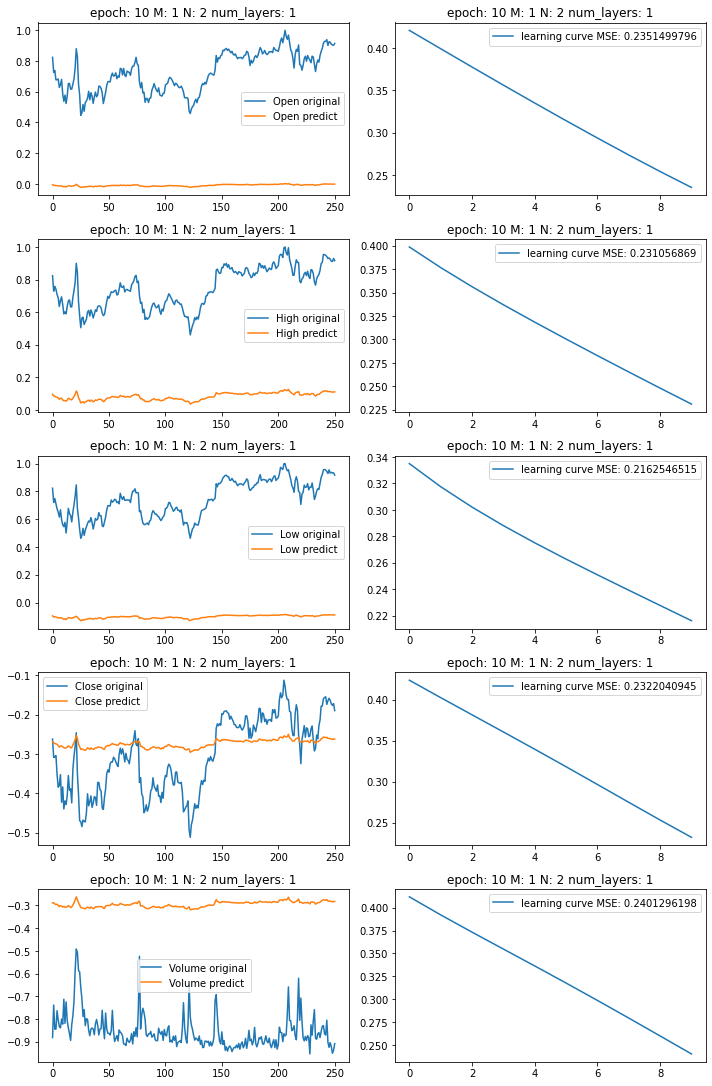

In [9]:
def hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list):
    num_epochs = epochs_list
    y_train_lstm_list, y_train_pred_list, pred_vali_plot_list, y_vali_lstm_plot_list, loss_rate_list = [], [], [], [], []
    for i in head_names:
        pf[i] = scaler.fit_transform(pf[i].values.reshape(-1,1))
    volume = pf[head_names_original]
    x_train, y_train, x_vali, y_vali = split_data(volume, N, M)
    x_train = torch.tensor(x_train).float()
    x_vali = torch.tensor(x_vali).float()
    y_train_lstm = torch.tensor(y_train).float()
    y_vali_lstm = torch.tensor(y_vali).float()
    
#     x_test, y_test = test_data(pf_test, N, M)
#     y_test = torch.tensor(y_test).float()
#     x_test = torch.tensor(x_test).float()

    for i in head_names:
        y_train_lstm, y_train_pred, pred_vali_plot, y_vali_lstm_plot, loss_rate = calculate(volume, N, 
            M, num_epochs, num_layers, i, x_train, x_vali, y_train_lstm, y_vali_lstm)
        y_train_lstm_list.append(y_train_lstm)
        y_train_pred_list.append(y_train_pred)
        loss_rate_list.append(loss_rate)
        pred_vali_plot_list.append(pred_vali_plot) 
        y_vali_lstm_plot_list.append(y_vali_lstm_plot)
    x = []

    for i in range(len(y_vali_lstm_plot_list[0])):
        x.append(i)
    fig = plt.figure(figsize=(10, 30))
    counter = 0
    for h in range(len(head_names)):
        for t in range(len(y_vali_lstm_plot_list[h])):
            temp = 0
            for q in range(M):
                temp += (1/M)*y_vali_lstm_plot_list[h][t][q][h]
            y_vali_lstm_plot_list[h][t] = temp
        for t in range(len(pred_vali_plot_list[h])):
            temp = 0
            for q in range(M):
                temp += (1/M)*pred_vali_plot_list[h][t][q][h]
            pred_vali_plot_list[h][t] = temp
    for i in range(len(head_names)):
        counter+=1
        ax = plt.subplot(len(head_names)*2, 2, counter)
        title = 'epoch: '+ str(epochs_list)+' M: '+str(M)+' N: '+str(N)+ ' num_layers: '+str(num_layers)
        ax.set_title(title)
        plt.title = head_names[i]
        
        plt.plot(x,y_vali_lstm_plot_list[i], label = head_names[i]+' original')
        plt.plot(x,pred_vali_plot_list[i], label = head_names[i]+' predict')
        x_learning_curve = []
        plt.legend()
        counter+=1
        for k in range(len(loss_rate_list[i])):
            x_learning_curve.append(k)
        ax = plt.subplot(len(head_names)*2, 2, counter)
        title = 'epoch: '+ str(epochs_list)+' M: '+str(M)+' N: '+str(N)+ ' num_layers: '+str(num_layers)
        ax.set_title(title)
        plt.plot(x_learning_curve, loss_rate_list[i], label = 'learning curve MSE: '+str(round(loss_rate_list[i][-1], 10)))
        plt.legend()
        plt.tight_layout()
    plt.legend()
    return y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list


num_layers = 1
use_all_data = True
epochs_list = 10
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anacon

Epoch  20 MSE:  0.10043061524629593
Training time: 0.0836191177368164
Epoch  20 MSE:  0.14048828184604645
Training time: 0.0805509090423584
Epoch  20 MSE:  0.08155655115842819
Training time: 0.08780217170715332
Epoch  20 MSE:  0.1393500417470932
Training time: 0.06827712059020996
Epoch  20 MSE:  0.0907612219452858
Training time: 0.08614110946655273


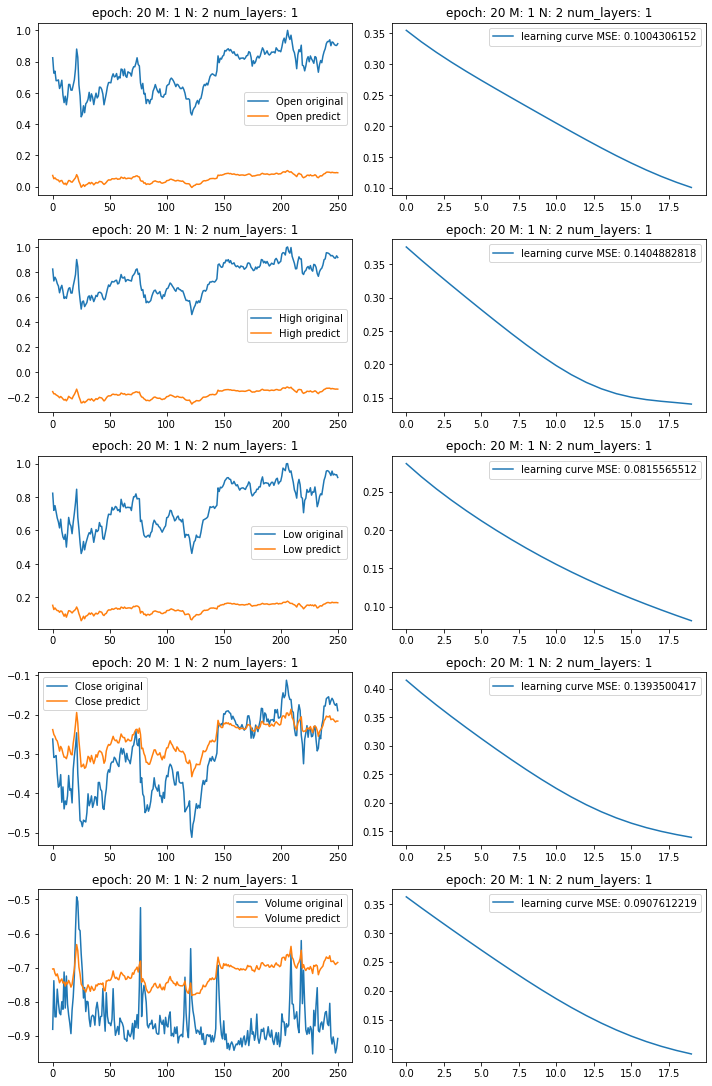

In [10]:

num_layers = 1
use_all_data = True
epochs_list = 20
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anacon

Epoch  30 MSE:  0.046617552638053894
Training time: 0.11816096305847168
Epoch  30 MSE:  0.08156874030828476
Training time: 0.11450982093811035
Epoch  30 MSE:  0.06795501708984375
Training time: 0.10158801078796387
Epoch  30 MSE:  0.06210631877183914
Training time: 0.10217809677124023
Epoch  30 MSE:  0.08251851052045822
Training time: 0.10436201095581055


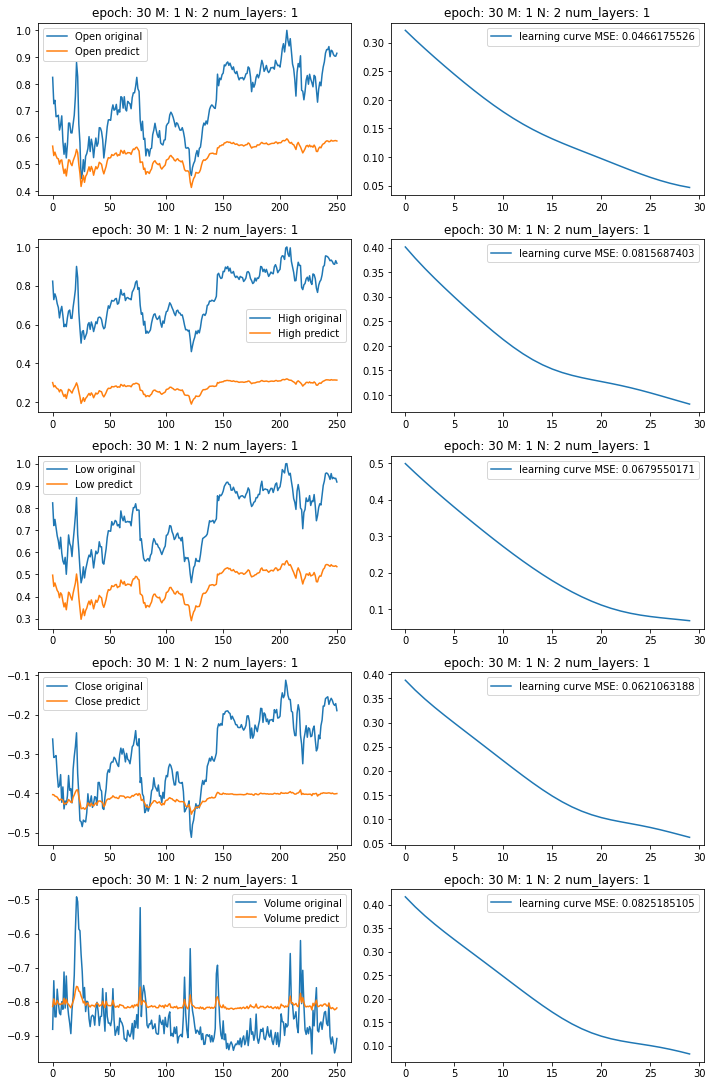

In [11]:


num_layers = 1
use_all_data = True
epochs_list = 30
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)




/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anacon

Epoch  50 MSE:  0.02522953972220421
Training time: 0.16986489295959473
Epoch  50 MSE:  0.0113654350861907
Training time: 0.17391014099121094
Epoch  50 MSE:  0.020989255979657173
Training time: 0.16869306564331055
Epoch  50 MSE:  0.030521996319293976
Training time: 0.16791296005249023
Epoch  50 MSE:  0.01958400197327137
Training time: 0.16819190979003906


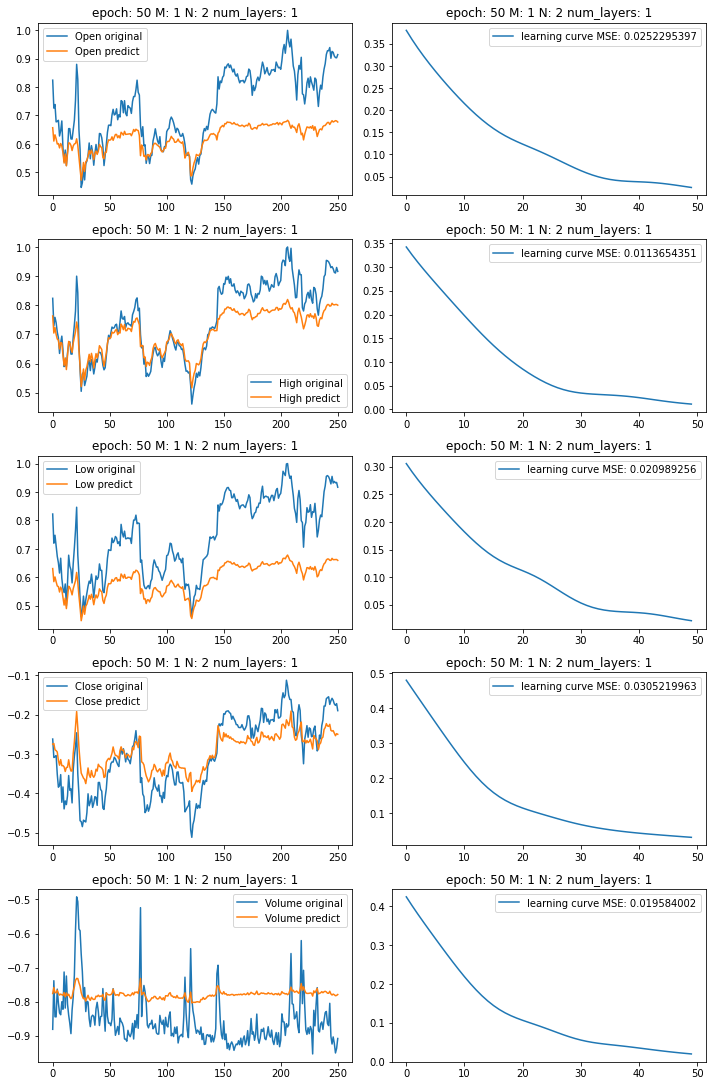

In [12]:


num_layers = 1
use_all_data = True
epochs_list = 50
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anacon

Epoch  100 MSE:  0.004786584060639143
Training time: 0.3478579521179199
Epoch  100 MSE:  0.004671152215451002
Training time: 0.3458240032196045
Epoch  100 MSE:  0.0032043680548667908
Training time: 0.33810997009277344
Epoch  100 MSE:  0.0027132772374898195
Training time: 0.3431830406188965
Epoch  100 MSE:  0.0030612864065915346
Training time: 0.34635424613952637


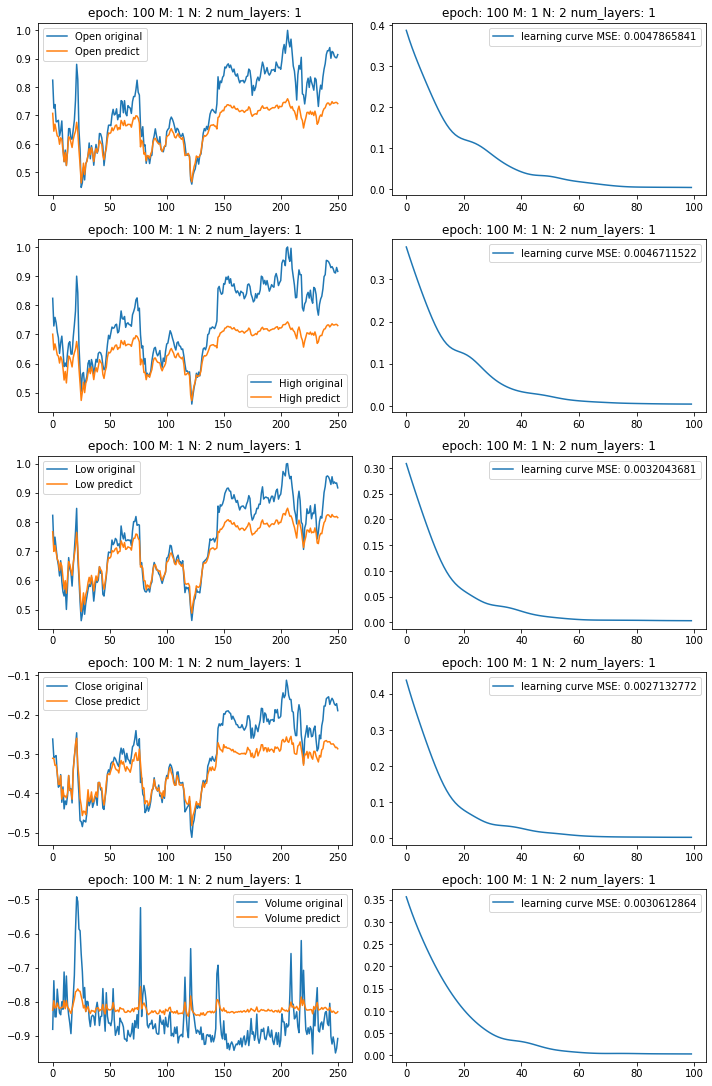

In [13]:

num_layers = 1
use_all_data = True
epochs_list = 100
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anacon

Epoch  200 MSE:  0.0030448182951658964
Training time: 0.6906270980834961
Epoch  200 MSE:  0.001830090070143342
Training time: 0.8043069839477539
Epoch  200 MSE:  0.00200277054682374
Training time: 0.6851530075073242
Epoch  200 MSE:  0.0018629085971042514
Training time: 0.7083590030670166
Epoch  200 MSE:  0.002974208677187562
Training time: 0.8229162693023682


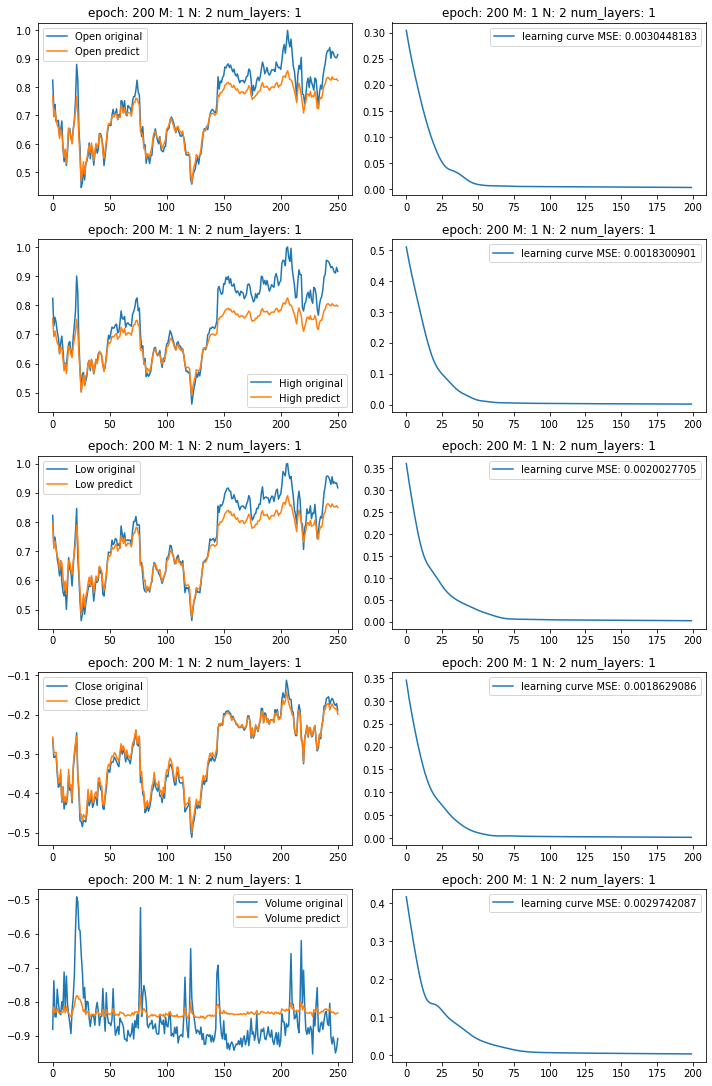

In [14]:

num_layers = 1
use_all_data = True
epochs_list = 200
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anacon

Epoch  500 MSE:  0.00023176100512500852
Training time: 1.9478697776794434
Epoch  500 MSE:  0.0001863126817625016
Training time: 1.6917169094085693
Epoch  500 MSE:  0.00022500107297673821
Training time: 1.7441279888153076
Epoch  500 MSE:  0.00019077961042057723
Training time: 1.7217819690704346
Epoch  500 MSE:  0.0002419923257548362
Training time: 1.7139949798583984


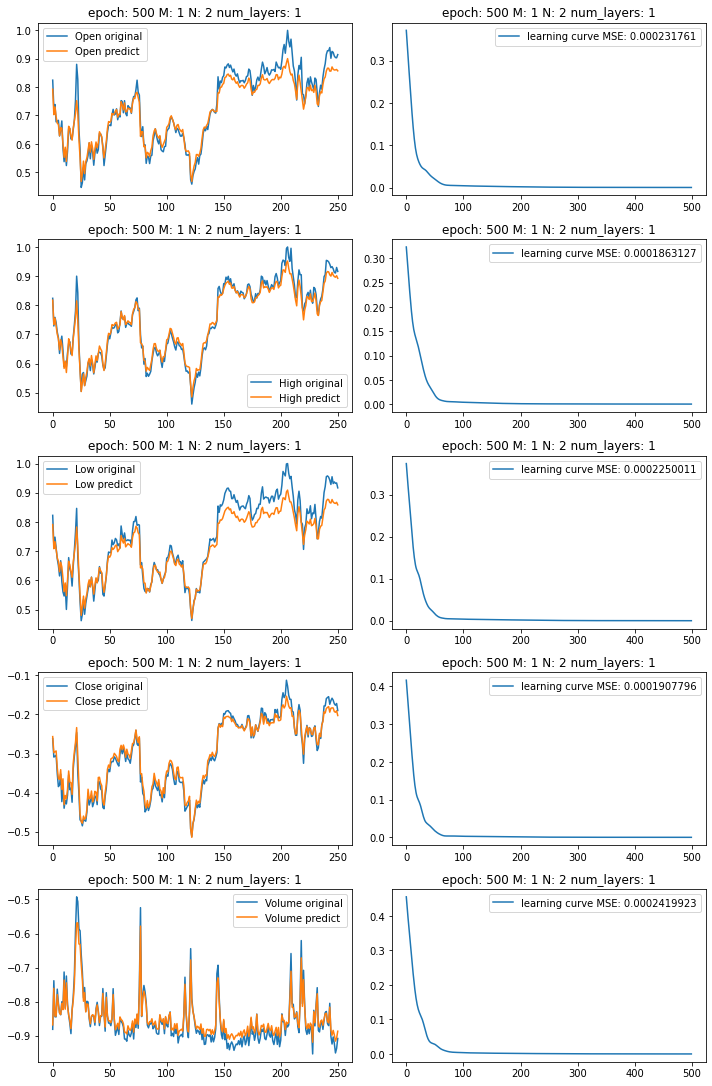

In [15]:


num_layers = 1
use_all_data = True
epochs_list = 500
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anacon

Epoch  1000 MSE:  6.920722807990387e-05
Training time: 3.5315120220184326
Epoch  1000 MSE:  7.977864879649132e-05
Training time: 3.3826498985290527
Epoch  1000 MSE:  7.718702545389533e-05
Training time: 3.390962839126587
Epoch  1000 MSE:  7.976651249919087e-05
Training time: 3.455911159515381
Epoch  1000 MSE:  0.000104038706922438
Training time: 3.927353858947754


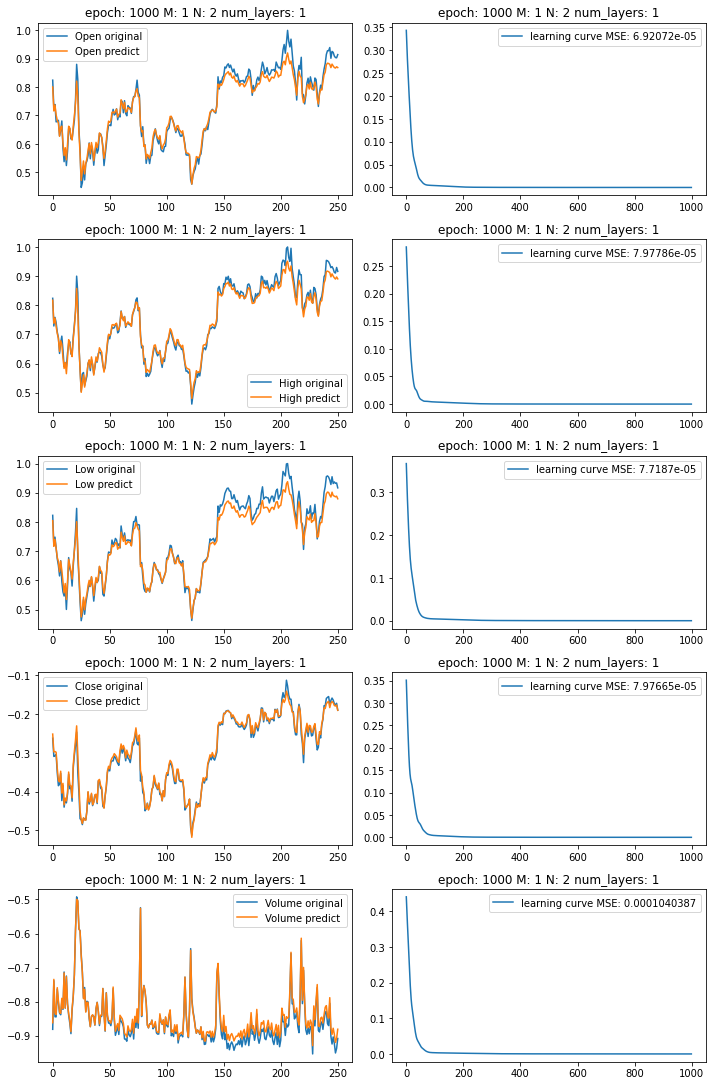

In [16]:


num_layers = 1
use_all_data = True
epochs_list = 1000
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mygreatenvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anacon

Epoch  3000 MSE:  3.3834134228527546e-05
Training time: 10.71983289718628
Epoch  3000 MSE:  3.30310249410104e-05
Training time: 10.108549118041992
Epoch  3000 MSE:  2.883728848246392e-05
Training time: 10.125911235809326
Epoch  3000 MSE:  2.8776250474038534e-05
Training time: 10.673036098480225
Epoch  3000 MSE:  4.165382051724009e-05
Training time: 10.969383239746094


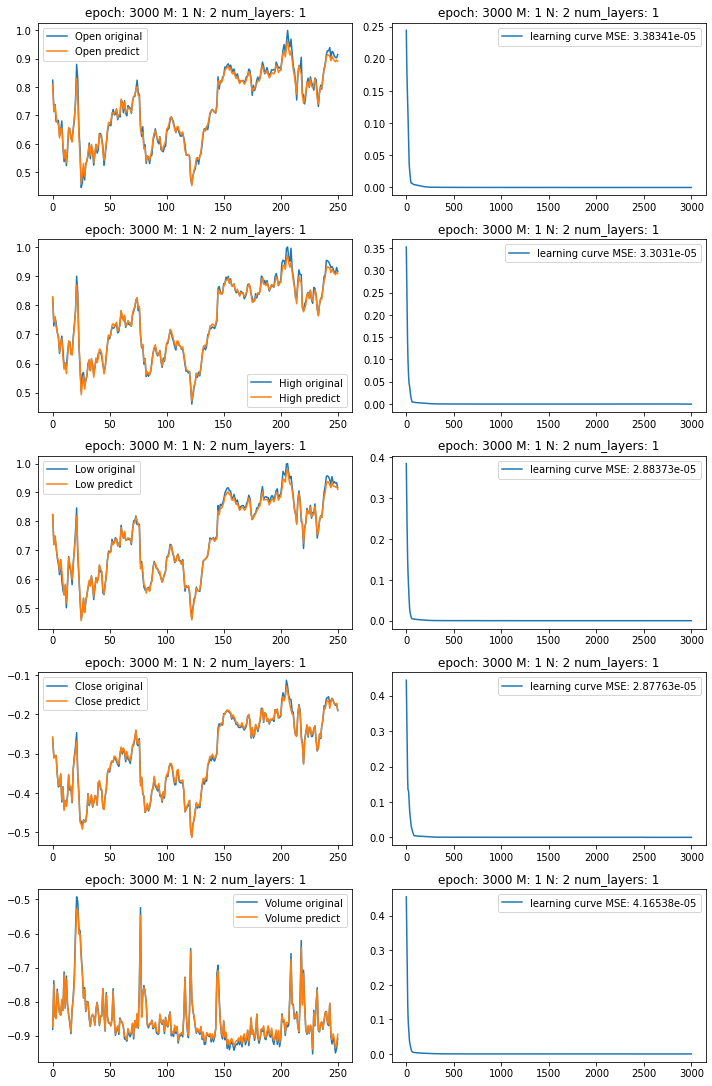

In [17]:


num_layers = 1
use_all_data = True
epochs_list = 3000
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

# Testing